In [335]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.decomposition import PCA

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


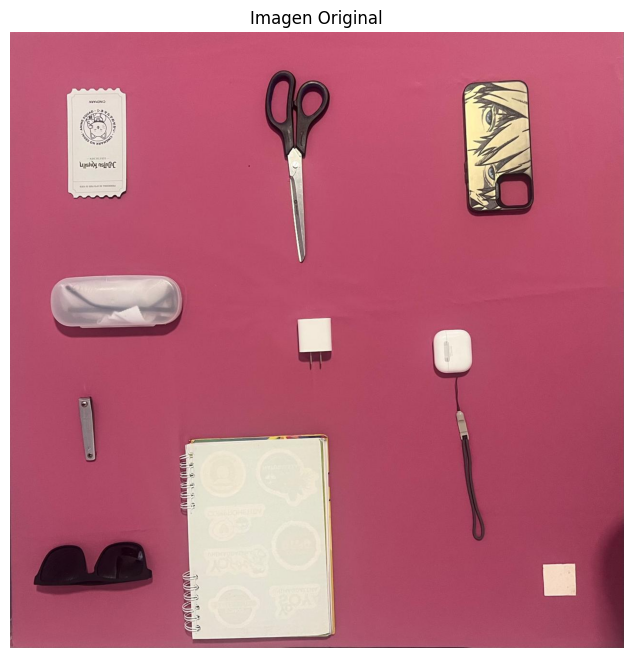

In [336]:
from google.colab import files
from google.colab import drive

def cargar_imagen_desde_drive(filepath):
    """Carga la imagen desde una ruta especificada en Google Drive"""
    img = cv2.imread(filepath)
    if img is None:
        print(f"Error: No se pudo cargar la imagen desde '{filepath}'. Verifica la ruta y que Google Drive esté montado.")
        return None, None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title('Imagen Original')
    plt.axis('off')
    plt.show()

    return img, img_rgb

# Ejecutar para cargar imagen desde Google Drive
drive.mount('/content/gdrive')
filepath = '/content/gdrive/MyDrive/Colab Notebooks/objetos10.jpeg'
imagen_original, imagen_rgb = cargar_imagen_desde_drive(filepath)

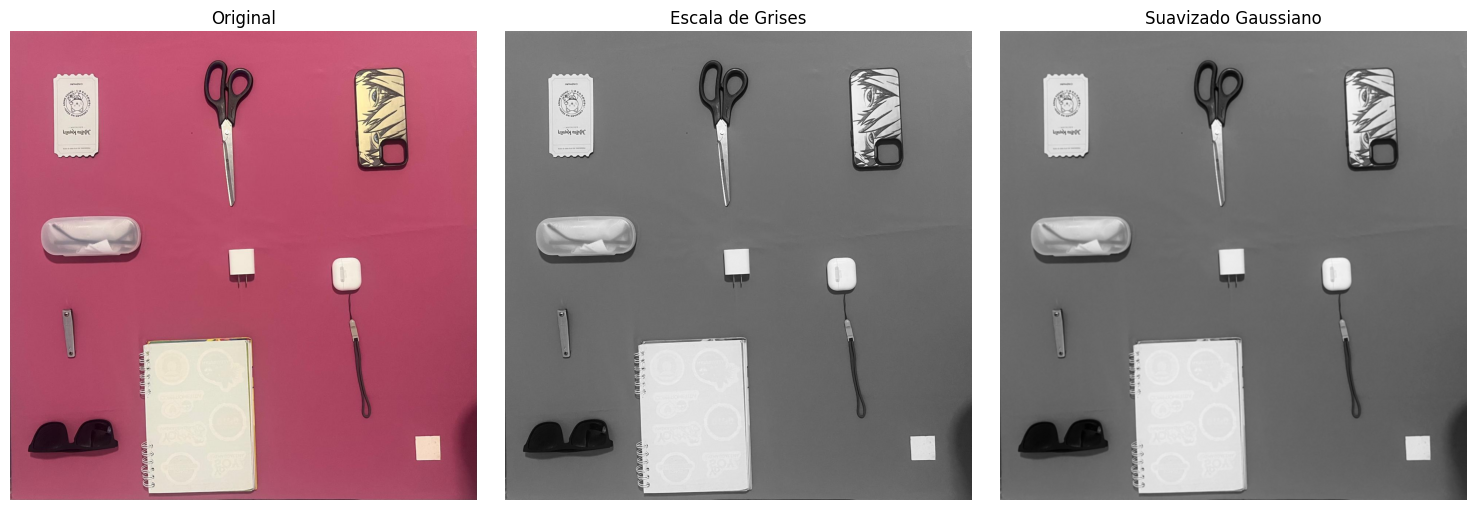

In [337]:
def preprocesar_imagen(img):
    """Aplica suavizado y conversión a escala de grises"""
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Suavizado gaussiano para reducir ruido
    suavizada = cv2.GaussianBlur(gray, (5, 5), 0)

    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(gray, cmap='gray')
    axes[1].set_title('Escala de Grises')
    axes[1].axis('off')

    axes[2].imshow(suavizada, cmap='gray')
    axes[2].set_title('Suavizado Gaussiano')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return gray, suavizada

# Ejecutar preprocesamiento
gray, suavizada = preprocesar_imagen(imagen_original)

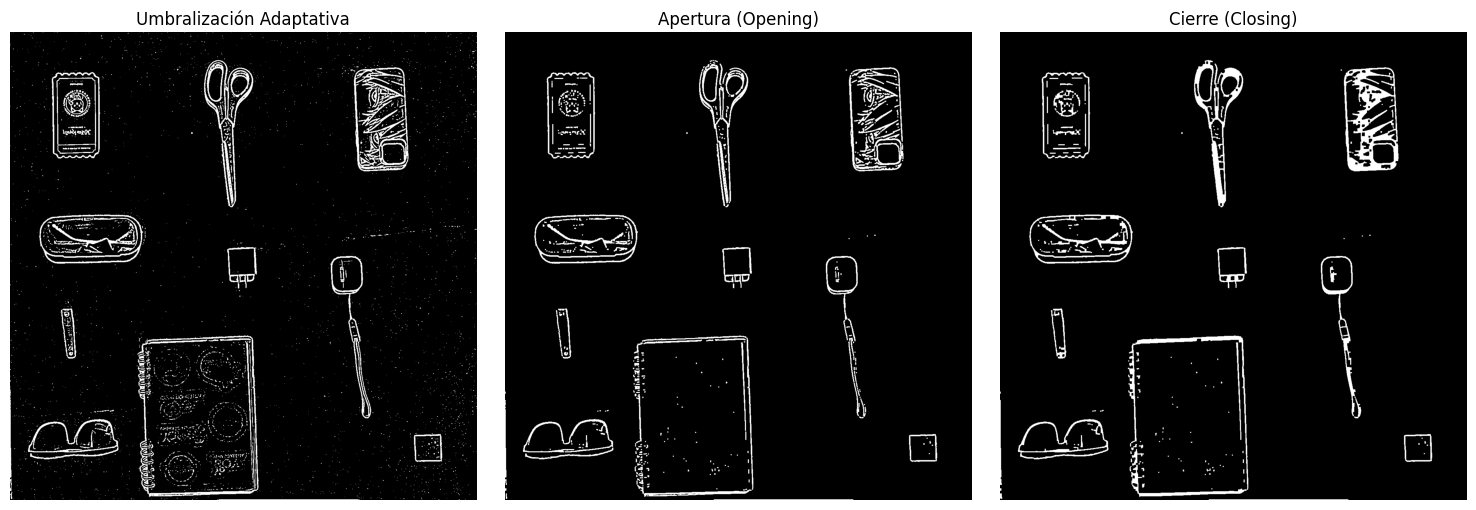

In [338]:
def umbralizar_imagen(img_suavizada):
    """Aplica umbralización adaptativa para segmentar objetos"""
    # Umbralización adaptativa
    umbral_adaptativo = cv2.adaptiveThreshold(
        img_suavizada, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Operaciones morfológicas para limpiar
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(umbral_adaptativo, cv2.MORPH_OPEN, kernel, iterations=1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(umbral_adaptativo, cmap='gray')
    axes[0].set_title('Umbralización Adaptativa')
    axes[0].axis('off')

    axes[1].imshow(opening, cmap='gray')
    axes[1].set_title('Apertura (Opening)')
    axes[1].axis('off')

    axes[2].imshow(closing, cmap='gray')
    axes[2].set_title('Cierre (Closing)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return closing

# Ejecutar umbralización
imagen_umbralizada = umbralizar_imagen(suavizada)

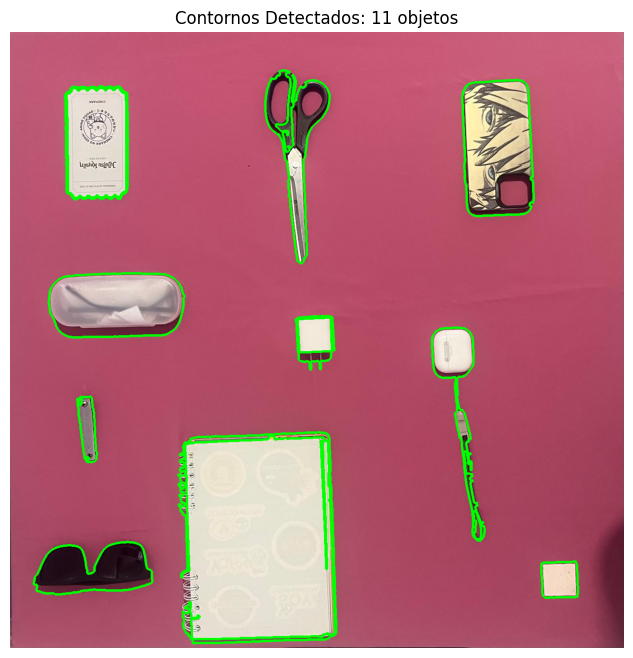

Total de objetos detectados: 11


In [339]:
def detectar_contornos(img_umbral, img_original):
    """Detecta y filtra contornos de los objetos"""
    contornos, _ = cv2.findContours(img_umbral, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar contornos por área mínima
    area_minima = 500
    contornos_filtrados = [c for c in contornos if cv2.contourArea(c) > area_minima]

    # Visualizar contornos
    img_contornos = img_original.copy()
    cv2.drawContours(img_contornos, contornos_filtrados, -1, (0, 255, 0), 3)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
    plt.title(f'Contornos Detectados: {len(contornos_filtrados)} objetos')
    plt.axis('off')
    plt.show()

    print(f"Total de objetos detectados: {len(contornos_filtrados)}")

    return contornos_filtrados

# Ejecutar detección de contornos
contornos = detectar_contornos(imagen_umbralizada, imagen_original)

Cuadrado de referencia encontrado
Factor de conversión: 15.40 píxeles/cm


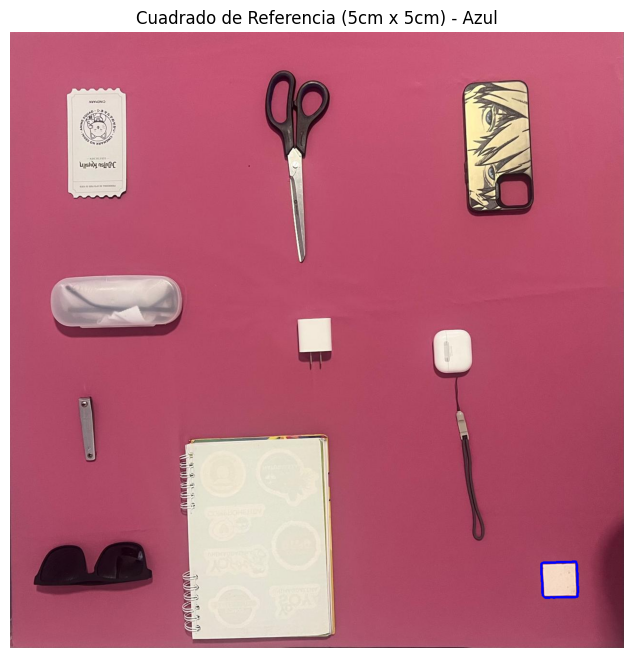

In [340]:

def identificar_referencia(contornos, tam_ref_cm=5.0):
    """Identifica el cuadrado de referencia de 5x5 cm"""
    cuadrado_ref = None
    pixeles_por_cm = None

    for contorno in contornos:
        # Aproximar el contorno a un polígono
        perimetro = cv2.arcLength(contorno, True)
        approx = cv2.approxPolyDP(contorno, 0.04 * perimetro, True)

        # Si tiene 4 vértices, podría ser el cuadrado
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(contorno)
            aspect_ratio = float(w) / h

            # Verificar que sea aproximadamente cuadrado (ratio cercano a 1)
            if 0.85 <= aspect_ratio <= 1.15:
                area = cv2.contourArea(contorno)
                # El cuadrado de referencia debería ser pequeño
                if cuadrado_ref is None or area < cv2.contourArea(cuadrado_ref):
                    cuadrado_ref = contorno
                    # Calcular píxeles por cm
                    pixeles_por_cm = w / tam_ref_cm

    return cuadrado_ref, pixeles_por_cm

cuadrado_referencia, px_por_cm = identificar_referencia(contornos)

if cuadrado_referencia is not None:
    print(f"Cuadrado de referencia encontrado")
    print(f"Factor de conversión: {px_por_cm:.2f} píxeles/cm")

    # Visualizar cuadrado de referencia
    img_ref = imagen_original.copy()
    cv2.drawContours(img_ref, [cuadrado_referencia], -1, (255, 0, 0), 3)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img_ref, cv2.COLOR_BGR2RGB))
    plt.title('Cuadrado de Referencia (5cm x 5cm) - Azul')
    plt.axis('off')
    plt.show()
else:
    print("ERROR: No se encontró el cuadrado de referencia")


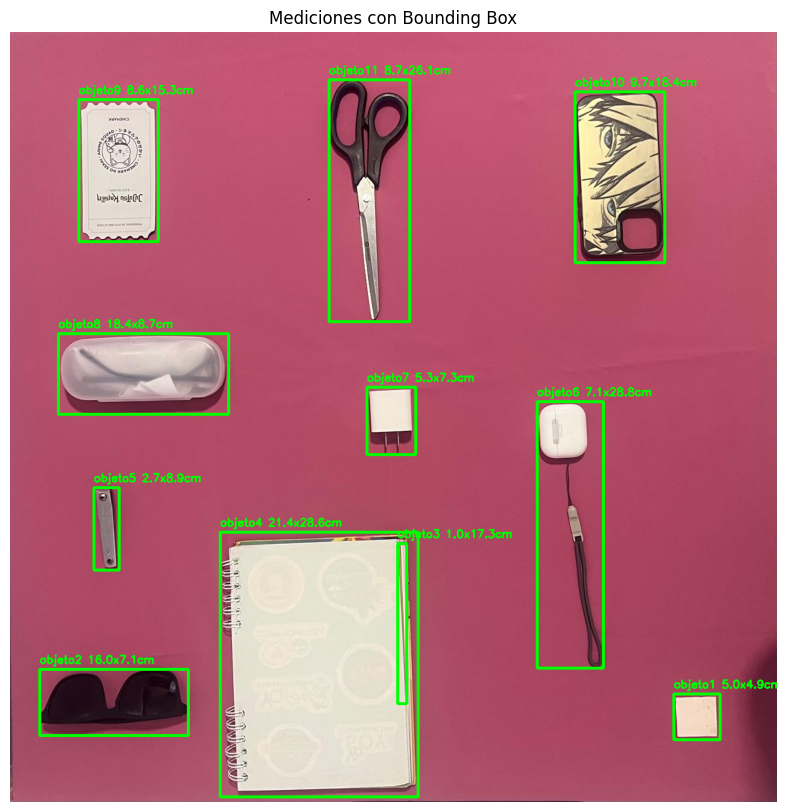

In [341]:
def medir_con_bounding_box(contornos, cuadrado_ref, px_por_cm, img_original):
    """Mide objetos usando Bounding Box"""
    if px_por_cm is None:
        print("ERROR: No se puede medir sin el cuadrado de referencia")
        return

    img_mediciones = img_original.copy()
    mediciones = []

    for i, contorno in enumerate(contornos):
        # Saltar el cuadrado de referencia
        #if np.array_equal(contorno, cuadrado_ref):
         #   continue

        # Calcular Bounding Box
        x, y, w, h = cv2.boundingRect(contorno)

        # Convertir a centímetros
        ancho_cm = w / px_por_cm
        alto_cm = h / px_por_cm

        # Dibujar bounding box
        cv2.rectangle(img_mediciones, (x, y), (x + w, y + h), (0, 255, 0), 3)

        # Añadir texto con medidas
        texto = f"objeto{i + 1 } {ancho_cm:.1f}x{alto_cm:.1f}cm"
        cv2.putText(img_mediciones, texto, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        mediciones.append({
            'objeto': i + 1,
            'ancho_cm': ancho_cm,
            'alto_cm': alto_cm,
            'metodo': 'BoundingBox'
        })

    # Visualizar
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_mediciones, cv2.COLOR_BGR2RGB))
    plt.title('Mediciones con Bounding Box')
    plt.axis('off')
    plt.show()

    return mediciones

# Ejecutar medición con Bounding Box
mediciones_bbox = medir_con_bounding_box(contornos, cuadrado_referencia, px_por_cm, imagen_original)



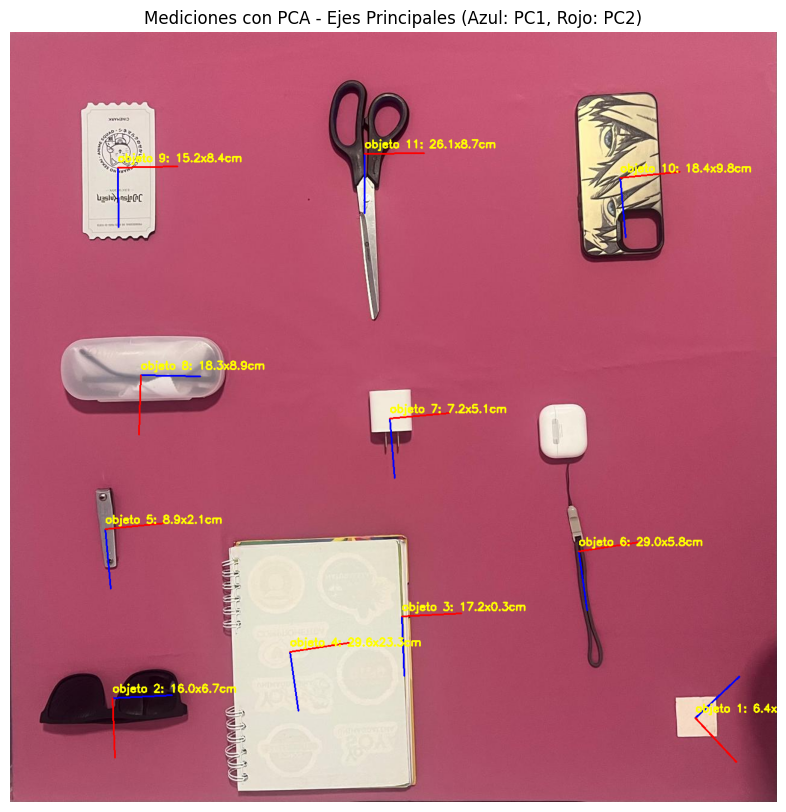

In [344]:
def medir_con_pca(contornos, cuadrado_ref, px_por_cm, img_original):
    """Mide objetos usando PCA (Análisis de Componentes Principales)"""
    if px_por_cm is None:
        print("ERROR: No se puede medir sin el cuadrado de referencia")
        return

    img_pca = img_original.copy()
    mediciones = []

    for i, contorno in enumerate(contornos):
        # Saltar el cuadrado de referencia
        #if np.array_equal(contorno, cuadrado_ref):
        #    continue

        # Obtener puntos del contorno
        puntos = contorno.reshape(-1, 2).astype(float)

        if len(puntos) < 5:
            continue

        # Aplicar PCA
        pca = PCA(n_components=2)
        pca.fit(puntos)

        # Obtener componentes principales
        componentes = pca.components_
        varianza = pca.explained_variance_

        # Calcular dimensiones en dirección de componentes principales
        puntos_transformados = pca.transform(puntos)
        ancho_px = np.max(puntos_transformados[:, 0]) - np.min(puntos_transformados[:, 0])
        alto_px = np.max(puntos_transformados[:, 1]) - np.min(puntos_transformados[:, 1])

        # Convertir a centímetros
        ancho_cm = ancho_px / px_por_cm
        alto_cm = alto_px / px_por_cm

        # Calcular centro y ángulo
        centro = np.mean(puntos, axis=0).astype(int)
        angulo = np.arctan2(componentes[0, 1], componentes[0, 0]) * 180 / np.pi

        # Dibujar ejes principales
        escala = 100
        eje1 = (int(centro[0] + escala * componentes[0, 0]),
                int(centro[1] + escala * componentes[0, 1]))
        eje2 = (int(centro[0] + escala * componentes[1, 0]),
                int(centro[1] + escala * componentes[1, 1]))

        cv2.line(img_pca, tuple(centro), eje1, (255, 0, 0), 2)
        cv2.line(img_pca, tuple(centro), eje2, (0, 0, 255), 2)

        # Añadir texto
        texto = f"objeto {i + 1}: {ancho_cm:.1f}x{alto_cm:.1f}cm"
        cv2.putText(img_pca, texto, (centro[0], centro[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

        mediciones.append({
            'objeto': i + 1,
            'ancho_cm': ancho_cm,
            'alto_cm': alto_cm,
            'angulo': angulo,
            'metodo': 'PCA'
        })

    # Visualizar
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(img_pca, cv2.COLOR_BGR2RGB))
    plt.title('Mediciones con PCA - Ejes Principales (Azul: PC1, Rojo: PC2)')
    plt.axis('off')
    plt.show()

    return mediciones

# Ejecutar medición con PCA
mediciones_pca = medir_con_pca(contornos, cuadrado_referencia, px_por_cm, imagen_original)


In [343]:
def comparar_resultados(mediciones_bbox, mediciones_pca):
    """Compara y muestra resultados de ambos métodos"""
    print("\n" + "="*70)
    print("RESULTADOS DE MEDICIONES")
    print("="*70)

    for i in range(max(len(mediciones_bbox), len(mediciones_pca))):
        print(f"\nOBJETO {i + 1}:")
        print("-" * 70)

        if i < len(mediciones_bbox):
            bbox = mediciones_bbox[i]
            print(f"  Bounding Box: {bbox['ancho_cm']:.2f} cm x {bbox['alto_cm']:.2f} cm")

        if i < len(mediciones_pca):
            pca = mediciones_pca[i]
            print(f"  PCA:          {pca['ancho_cm']:.2f} cm x {pca['alto_cm']:.2f} cm")
            print(f"  Ángulo:       {pca['angulo']:.1f}°")

        if i < len(mediciones_bbox) and i < len(mediciones_pca):
            diff_ancho = abs(bbox['ancho_cm'] - pca['ancho_cm'])
            diff_alto = abs(bbox['alto_cm'] - pca['alto_cm'])
            print(f"  Diferencia:   {diff_ancho:.2f} cm (ancho), {diff_alto:.2f} cm (alto)")

    print("\n" + "="*70)

# Ejecutar comparación
comparar_resultados(mediciones_bbox, mediciones_pca)


RESULTADOS DE MEDICIONES

OBJETO 1:
----------------------------------------------------------------------
  Bounding Box: 5.00 cm x 4.94 cm
  PCA:          6.42 cm x 6.60 cm
  Ángulo:       -43.0°
  Diferencia:   1.42 cm (ancho), 1.67 cm (alto)

OBJETO 2:
----------------------------------------------------------------------
  Bounding Box: 16.04 cm x 7.14 cm
  PCA:          15.99 cm x 6.66 cm
  Ángulo:       -2.7°
  Diferencia:   0.05 cm (ancho), 0.48 cm (alto)

OBJETO 3:
----------------------------------------------------------------------
  Bounding Box: 0.97 cm x 17.27 cm
  PCA:          17.23 cm x 0.34 cm
  Ángulo:       87.5°
  Diferencia:   16.26 cm (ancho), 16.93 cm (alto)

OBJETO 4:
----------------------------------------------------------------------
  Bounding Box: 21.36 cm x 28.57 cm
  PCA:          29.56 cm x 23.25 cm
  Ángulo:       81.6°
  Diferencia:   8.20 cm (ancho), 5.32 cm (alto)

OBJETO 5:
----------------------------------------------------------------------
 